# Analysis of car accidents in Barcelona using Pandas, Matplotlib, and Folium

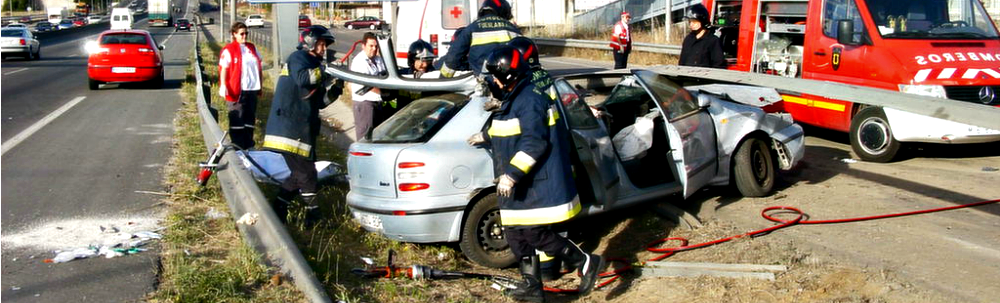

In this project, we employ the dataset that contains the accidents managed by the local police in the city of Barcelona in 2017. This dataset includes information such as the number of injuries by severity, the number of vehicles involved, the date, and the geographic location of the accident.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium import plugins
import calendar
print('Done')

Done


In [2]:
# importing dataset
data = pd.read_csv(r'C:\Users\ABDULAZEEZ R.O\Desktop\1\Dataset\accidents_2017.csv')
data.head()

,Id,District Name,Neighborhood Name,Street,Weekday,Month,Day,Hour,Part of the day,Mild injuries,Serious injuries,Victims,Vehicles involved,Longitude,Latitude
0,2017S008429,Unknown,Unknown,Número 27 ...,Friday,October,13,8,Morning,2,0,2,2,2.125624,41.340045
1,2017S007316,Unknown,Unknown,Número 3 Zona Franca / Número 50 Zona Franca ...,Friday,September,1,13,Morning,2,0,2,2,2.120452,41.339426
2,2017S010210,Unknown,Unknown,Litoral (Besòs) ...,Friday,December,8,21,Afternoon,5,0,5,2,2.167356,41.360885
3,2017S006364,Unknown,Unknown,Número 3 Zona Franca ...,Friday,July,21,2,Night,1,0,1,2,2.124529,41.337668
4,2017S004615,Sant Martí,el Camp de l'Arpa del Clot,Las Navas de Tolosa ...,Thursday,May,25,14,Afternoon,1,0,1,3,2.185272,41.416365


## Exploratory data analysis and data cleaning

In [3]:
# checking the dimension of our data
nrows, ncol = data.shape
print(f'The number of observations are {nrows}, while the number of our features are {ncol}')

The number of observations are 10339, while the number of our features are 15


In [4]:
list(data.columns)

['Id',
 'District Name',
 'Neighborhood Name',
 'Street',
 'Weekday',
 'Month',
 'Day',
 'Hour',
 'Part of the day',
 'Mild injuries',
 'Serious injuries',
 'Victims',
 'Vehicles involved',
 'Longitude',
 'Latitude']

As we can observe, our data contains 15 columns: Id, District Name, Neighborhood, Street, Weekday, Month, Day, Hour, Part of the day, Mild injuries, Serious injuries, Victims, Vehicles involved, Longitude, Latitude.

Let's replace the space in  our columns with underscore

In [5]:
# Replacing spaces with underscore
data.columns = data.columns.str.replace(' ', '_' )
data.columns

Index(['Id', 'District_Name', 'Neighborhood_Name', 'Street', 'Weekday',
       'Month', 'Day', 'Hour', 'Part_of_the_day', 'Mild_injuries',
       'Serious_injuries', 'Victims', 'Vehicles_involved', 'Longitude',
       'Latitude'],
      dtype='object')

In [6]:
# checking the information of our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10339 entries, 0 to 10338
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 10339 non-null  object 
 1   District_Name      10339 non-null  object 
 2   Neighborhood_Name  10339 non-null  object 
 3   Street             10339 non-null  object 
 4   Weekday            10339 non-null  object 
 5   Month              10339 non-null  object 
 6   Day                10339 non-null  int64  
 7   Hour               10339 non-null  int64  
 8   Part_of_the_day    10339 non-null  object 
 9   Mild_injuries      10339 non-null  int64  
 10  Serious_injuries   10339 non-null  int64  
 11  Victims            10339 non-null  int64  
 12  Vehicles_involved  10339 non-null  int64  
 13  Longitude          10339 non-null  float64
 14  Latitude           10339 non-null  float64
dtypes: float64(2), int64(6), object(7)
memory usage: 1.2+ MB


In [7]:
# checking the missing values
data.isnull().sum().any()

False

Apparently, there are no missing values, since all the columns have 10339 entries. However, some entries contain the string Unknown. We can replace this string by nan, and recheck the missing values.

In [8]:
# replace Unknown with nan
data.replace('Unknown', np.nan, inplace = True)

# rechecking the missing values
data.isnull().sum().any()

True

Now, There are missing values

In [9]:
# which column has a missing values

total = data.isnull().sum().sort_values(ascending = False)
perct = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending = False)
missg = pd.concat([total, perct], axis = 1, keys = ['Total', 'Percent'])
missing = missg[missg['Total'] > 0]
missing

,Total,Percent
Neighborhood_Name,27,0.261147
District_Name,27,0.261147


As we can see, only the columns Neighborhood_Name and District_Name contain missing values, and the percentage of missing values are less than one percent. Since we are not going to use these columns in our further analysis, we do not need to take into consideration the null values. We won’t analyze where the accident happened by using the District Name and Neighbourhood Name, but by using the Longitude and Latitude.

Before we start to draw conclusions using our data, we are going to clean it. The first cleaning step consists of dropping unnecessary columns to simplify the dataframe.

In [10]:
# dropping unnecesaary columns
data.drop(['District_Name','Neighborhood_Name','Part_of_the_day'], axis=1 ,inplace=True)

# Columns after dropping.
data.columns

Index(['Id', 'Street', 'Weekday', 'Month', 'Day', 'Hour', 'Mild_injuries',
       'Serious_injuries', 'Victims', 'Vehicles_involved', 'Longitude',
       'Latitude'],
      dtype='object')

After dropping the columns, we modify some data types.

In [11]:
# checking the data type
data.dtypes

Id                    object
Street                object
Weekday               object
Month                 object
Day                    int64
Hour                   int64
Mild_injuries          int64
Serious_injuries       int64
Victims                int64
Vehicles_involved      int64
Longitude            float64
Latitude             float64
dtype: object

As we can observe, Month, Day, and Hour are not datetime objects. We can easily combine those columns into a single column

In [12]:
# Add a column with the year in this case 2017
data['year'] = np.repeat(2017,data.shape[0])
data.head(4)

,Id,Street,Weekday,Month,Day,Hour,Mild_injuries,Serious_injuries,Victims,Vehicles_involved,Longitude,Latitude,year
0,2017S008429,Número 27 ...,Friday,October,13,8,2,0,2,2,2.125624,41.340045,2017
1,2017S007316,Número 3 Zona Franca / Número 50 Zona Franca ...,Friday,September,1,13,2,0,2,2,2.120452,41.339426,2017
2,2017S010210,Litoral (Besòs) ...,Friday,December,8,21,5,0,5,2,2.167356,41.360885,2017
3,2017S006364,Número 3 Zona Franca ...,Friday,July,21,2,1,0,1,2,2.124529,41.337668,2017


Now, we can combine weekday, month, day, hour, and year into one single column called date. To avoid a ValueError, we have to convert month names into integers

In [13]:
# Obtain month names 
data.Month.unique()

array(['October', 'September', 'December', 'July', 'May', 'June',
       'January', 'April', 'March', 'November', 'February', 'August'],
      dtype=object)

In [14]:
# Month names to int
month_to_int = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

# Convert month names into numbers
data['Month'].replace(month_to_int, inplace=True)

# Obtain new month names
data.Month.unique()

array([10,  9, 12,  7,  5,  6,  1,  4,  3, 11,  2,  8], dtype=int64)

After the conversion, we can obtain a datetime column

In [15]:
# Combine columns month day hour and year to create a single datetime column.
data['date']=pd.to_datetime(data[['year', 'Month', 'Day','Hour']])

# check the first 5 columns.
data.head()

,Id,Street,Weekday,Month,Day,Hour,Mild_injuries,Serious_injuries,Victims,Vehicles_involved,Longitude,Latitude,year,date
0,2017S008429,Número 27 ...,Friday,10,13,8,2,0,2,2,2.125624,41.340045,2017,2017-10-13 08:00:00
1,2017S007316,Número 3 Zona Franca / Número 50 Zona Franca ...,Friday,9,1,13,2,0,2,2,2.120452,41.339426,2017,2017-09-01 13:00:00
2,2017S010210,Litoral (Besòs) ...,Friday,12,8,21,5,0,5,2,2.167356,41.360885,2017,2017-12-08 21:00:00
3,2017S006364,Número 3 Zona Franca ...,Friday,7,21,2,1,0,1,2,2.124529,41.337668,2017,2017-07-21 02:00:00
4,2017S004615,Las Navas de Tolosa ...,Thursday,5,25,14,1,0,1,3,2.185272,41.416365,2017,2017-05-25 14:00:00


In [16]:
# Extract the day
data['date'].dt.day

# Extract the hour
data['date'].dt.hour

# Extract the day of the week
data['date'].dt.dayofweek

0        4
1        4
2        4
3        4
4        3
        ..
10334    1
10335    2
10336    3
10337    4
10338    6
Name: date, Length: 10339, dtype: int64

Since we can access all the information we need related to the date of the accident using pandas.Series.dt attribute, we can drop columns month, year, hour, day, and day of the week, as they are not longer needed.


In [17]:
# Drop columns hour, day, month, year, weekday
data.drop(['Hour','Day','Month','year','Weekday'], axis=1, inplace=True)

# Dataframe columns
list(data.columns)

['Id',
 'Street',
 'Mild_injuries',
 'Serious_injuries',
 'Victims',
 'Vehicles_involved',
 'Longitude',
 'Latitude',
 'date']

Finally, we can drop the street column as well, since we are going to visualize where the accidents happened using only the longitude and latitude.

In [18]:
# Drop the street column
data.drop(['Street'], axis=1, inplace=True)

# First 5 rows of the dataframe
data.head()

,Id,Mild_injuries,Serious_injuries,Victims,Vehicles_involved,Longitude,Latitude,date
0,2017S008429,2,0,2,2,2.125624,41.340045,2017-10-13 08:00:00
1,2017S007316,2,0,2,2,2.120452,41.339426,2017-09-01 13:00:00
2,2017S010210,5,0,5,2,2.167356,41.360885,2017-12-08 21:00:00
3,2017S006364,1,0,1,2,2.124529,41.337668,2017-07-21 02:00:00
4,2017S004615,1,0,1,3,2.185272,41.416365,2017-05-25 14:00:00


In [19]:
# We have noticed that id has spaces at the end of the string
data.Id.loc[0]

'2017S008429    '

To easily access information about a car accident, we are going to set Id as the index of our data, removing the spaces present in the Id entries.

In [20]:
# remove the spaces in the entries of Id 
data.Id = data.Id.apply(lambda x: x.strip())

# Recheck the spaces
data.Id.loc[0]

'2017S008429'

### Checking the duplicates values in id before setting it as our index

The final cleaning step consists of evaluating whether there are duplicated entries in the data frame. If so, we will remove these duplicated entries from the data frame, as they represent the same car accident.

In [21]:
# Number of duplicates rows
data.duplicated(['Id']).sum()

4

In [22]:
# Print duplicated rows in Id.
data[data.duplicated(['Id'], keep = False)]

,Id,Mild_injuries,Serious_injuries,Victims,Vehicles_involved,Longitude,Latitude,date
84,2017S008856,1,0,1,1,2.203962,41.407568,2017-10-26 08:00:00
3079,2017S003750,1,0,1,1,2.168836,41.386306,2017-04-27 16:00:00
5222,2017S004447,1,0,1,1,2.209813,41.402218,2017-05-19 20:00:00
5799,2017S003286,1,0,1,1,2.136744,41.357598,2017-04-10 13:00:00
5800,2017S003286,1,0,1,1,2.136744,41.357598,2017-04-10 13:00:00
6492,2017S008856,1,0,1,1,2.203962,41.407568,2017-10-26 08:00:00
6979,2017S003750,1,0,1,1,2.168836,41.386306,2017-04-27 16:00:00
9211,2017S004447,1,0,1,1,2.209813,41.402218,2017-05-19 20:00:00


In [23]:
# Shape of the dataframe before removing duplicated columns
data.shape

(10339, 8)

In [24]:
# Drop duplicates.
data.drop_duplicates(['Id'], inplace = True)

In [25]:
# Shape after dropping duplicates.
data.shape

(10335, 8)

Now we can set our Id column as index of our dataset.

In [26]:
# We can set the Id as the index of our data
data.set_index('Id', inplace =  True)

data.head()

,Mild_injuries,Serious_injuries,Victims,Vehicles_involved,Longitude,Latitude,date
Id,,,,,,,
2017S008429,2,0,2,2,2.125624,41.340045,2017-10-13 08:00:00
2017S007316,2,0,2,2,2.120452,41.339426,2017-09-01 13:00:00
2017S010210,5,0,5,2,2.167356,41.360885,2017-12-08 21:00:00
2017S006364,1,0,1,2,2.124529,41.337668,2017-07-21 02:00:00
2017S004615,1,0,1,3,2.185272,41.416365,2017-05-25 14:00:00


In [27]:
# Now we can easily access information about a car accident using its Id.
data.loc['2017S004615']

Mild_injuries                          1
Serious_injuries                       0
Victims                                1
Vehicles_involved                      3
Longitude                        2.18527
Latitude                         41.4164
date                 2017-05-25 14:00:00
Name: 2017S004615, dtype: object

__Data cleaning finished! Now! We are ready to answer questions and draw conclusions using our data.__

## Answering questions and drawing conclusions

Exploratory data analysis and data cleaning are the steps that allow us to get a feeling about the dataset and to get the dataset ready to easily draw conclusions using it. Now! We are ready to answer the following questions using the dataset.

### How many accidents were registered by the police in Barcelona in 2017?

In [28]:
print('The total number of accidents registered by the police in Barcelona:{}'.format(data.shape[0]))

The total number of accidents registered by the police in Barcelona:10335


In 2017, 10335 accidents were registered by the police in Barcelona.

### Distribution of car accidents per month

In [29]:
mm = data.groupby(data.date.dt.month).count().date

# Replace the month integers by month names.
mm.index=[calendar.month_name[x] for x in range(1,13)]

mm

January      844
February     824
March        935
April        843
May          962
June         908
July         918
August       652
September    769
October      927
November     991
December     762
Name: date, dtype: int64

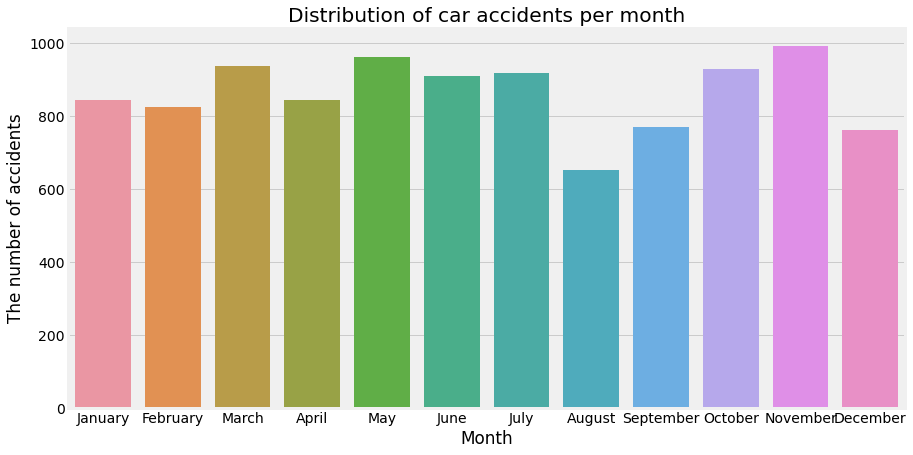

In [30]:
mm = data.groupby(data.date.dt.month).count().date

# Replace the month integers by month names.
mm.index=[calendar.month_name[x] for x in range(1,13)]

plt.figure(figsize = (15, 7))
plt.style.use('fivethirtyeight')
sns.barplot(x = mm.index, y = mm.values)

plt.title('Distribution of car accidents per month')
plt.xlabel('Month')
plt.ylabel('The number of accidents')
plt.show()

As we can observe, the number of accidents decreases in August and December. One reason could be that fewer people are driving to work in these months.

### Distribution of car accidents per day of the week

As we did with months, we can analyze the distribution of car accidents according to the day of the week

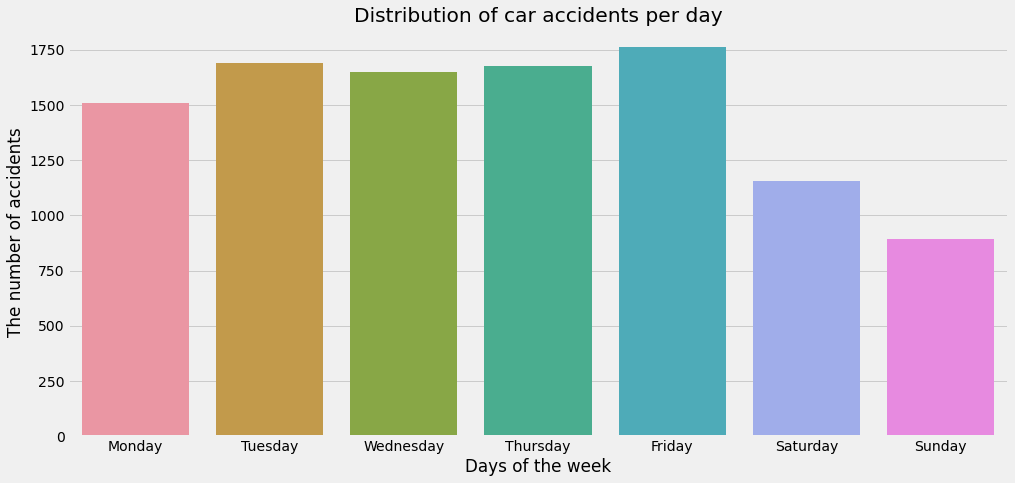

In [31]:
dw = data.groupby(data['date'].dt.dayofweek).count().date

# Replace the month integers by month names.
dw.index=[calendar.day_name[x] for x in range(0,7)]

plt.figure(figsize = (15, 7))
plt.style.use('fivethirtyeight')
sns.barplot(x = dw.index, y = dw.values)

plt.title('Distribution of car accidents per day')
plt.xlabel('Days of the week')
plt.ylabel('The number of accidents')
plt.show()

As shown in the plot above, the number of car accidents decrease at the weekend. Weekdays present an average of 1656 car accidents per day, around 600 more accidents than on weekends (on average 1025 car accidents per day).

The next plot depicts the number of accidents during each day of the year. As we can observe, there are between 10–50 accidents per day and the number of accidents on friday are as a rule much higher than the number of accidents on sunday.

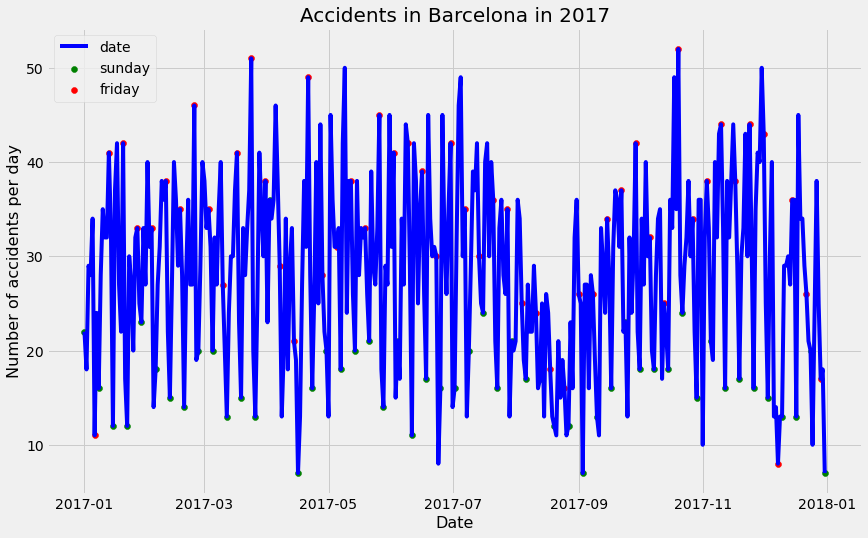

In [32]:
accidents = data.groupby(data['date'].dt.date).count().date

accidents.plot(figsize=(13,8), color='blue')

# sunday accidents
sundays = data.groupby(data[data['date'].dt.dayofweek==6].date.dt.date).count().date
plt.scatter(sundays.index, sundays, color='green', label='sunday')

# friday accidents
friday = data.groupby(data[data['date'].dt.dayofweek==4].date.dt.date).count().date
plt.scatter(friday.index, friday, color='red', label='friday')

# Title, x label and y label
plt.style.use('fivethirtyeight')
plt.title('Accidents in Barcelona in 2017', fontsize=20)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Number of accidents per day',fontsize=16);
plt.legend()

### Distribution of car accidents per hour

Following the same procedure as before, we plot the distribution of car accidents this time according to time.

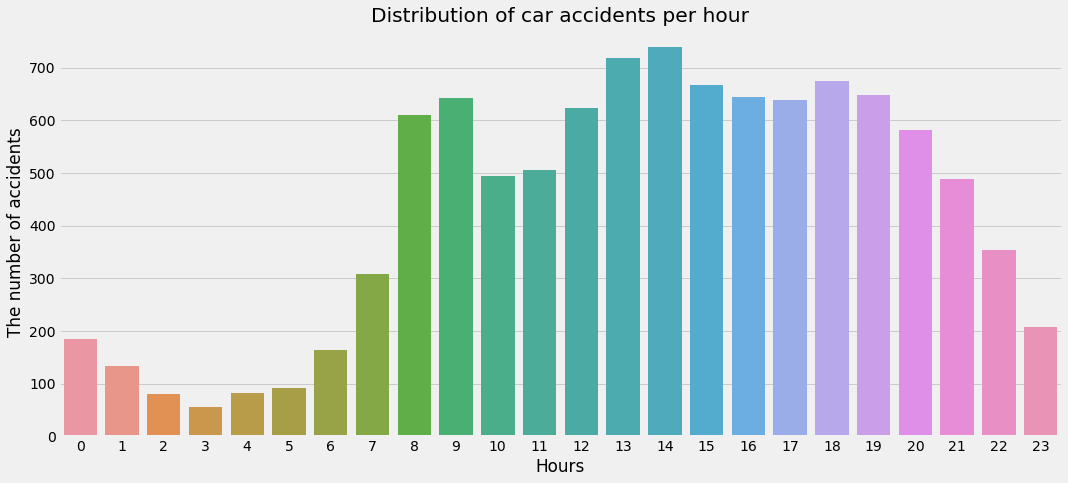

In [33]:
# Number of accident per hour
acc_hour = data.groupby(data['date'].dt.hour).count().date

plt.figure(figsize = (16, 7))
plt.style.use('fivethirtyeight')
sns.barplot(x = acc_hour.index, y = acc_hour.values)

plt.title('Distribution of car accidents per hour')
plt.xlabel('Hours')
plt.ylabel('The number of accidents')
plt.show()

As we can observe in the plot, the greater number of accidents occur in early-morning hours 8–9 and between 12 and 20.

### Distribution of car accidents per day of the week and hour

We can also analyze the number of accidents per day of the week and hour using a side-by-side bar plot. In this particular case, we use a horizontal plot for better visualization.

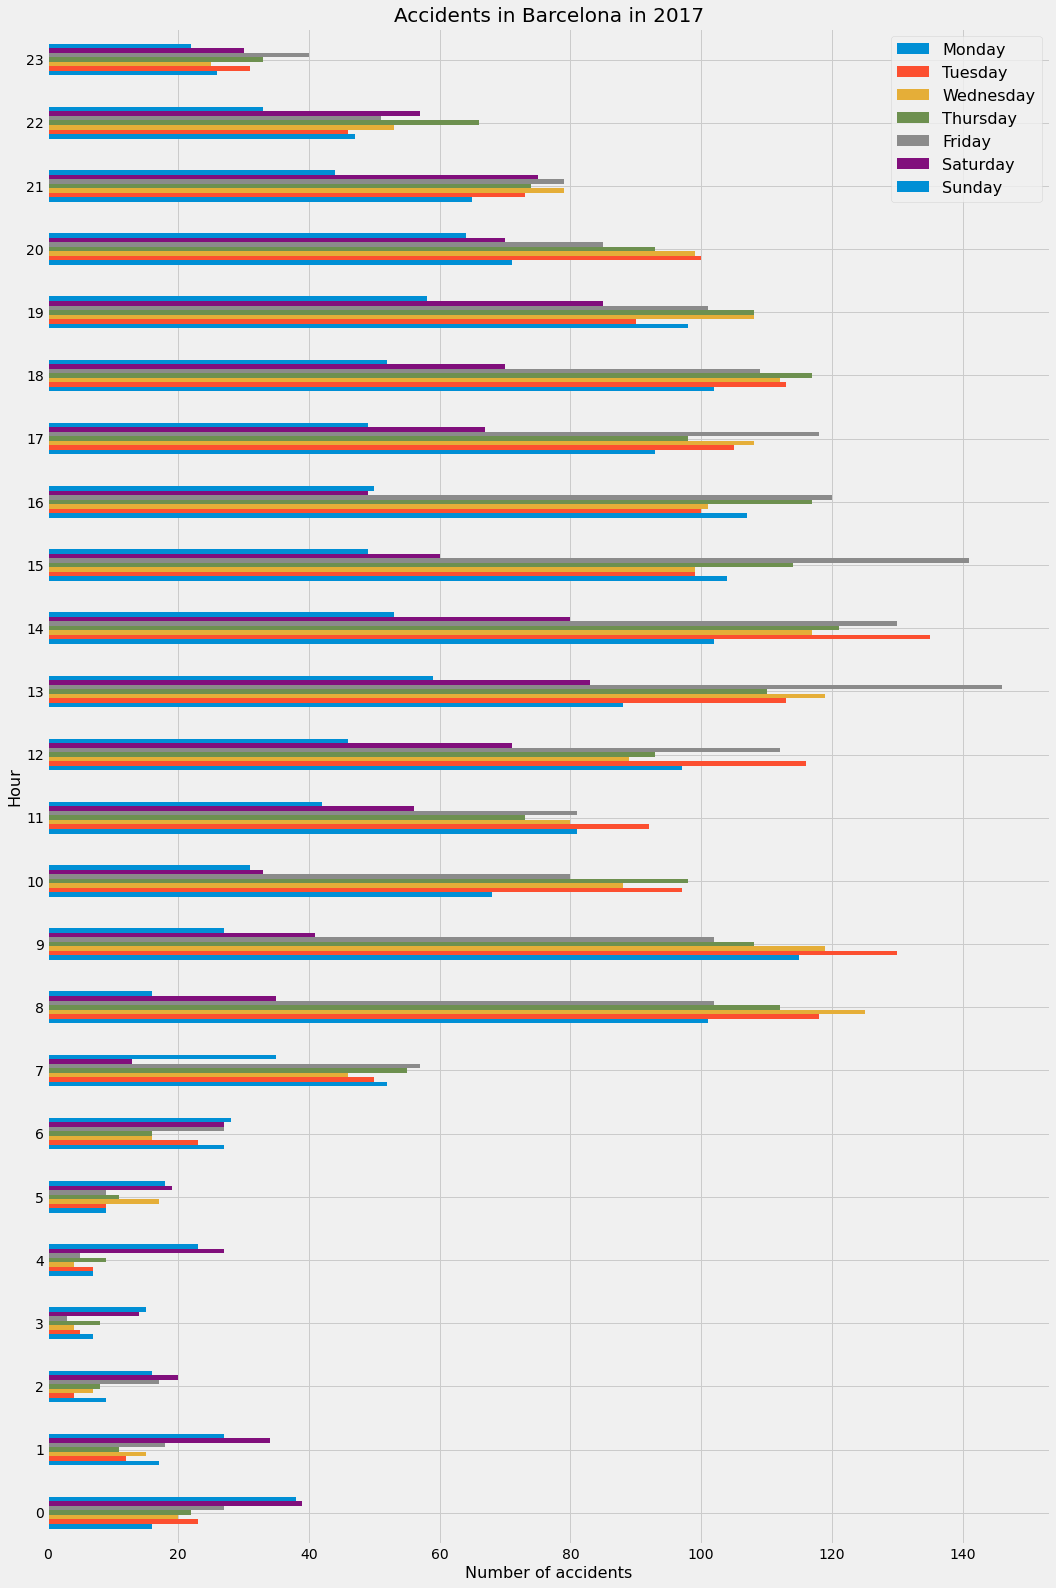

In [34]:
# Number of accident per hour and day
accidents_hour_day = data.groupby([data['date'].dt.hour.rename('hour'),data['date'].dt.dayofweek.rename('day')]).count().date

accidents_hour_day.unstack().plot(kind='barh', figsize=(16,26))

# title and x,y labels
plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=16)
plt.title('Accidents in Barcelona in 2017',fontsize=20)
plt.xlabel('Number of accidents',fontsize=16)
plt.ylabel('Hour',fontsize=16);

As we can easily observe, there are more accidents at night on weekends than during weekdays. On the contrary, there are much more accidents from early-morning (8) til afternoon (19) during weekdays than at the weekend.

__CONCLUSIONS__

1. August presents the lowest number of car accidents 651 in 2017. The rest of the months present a number of accidents around 800–900.
2. The number of car accidents decrease on weekends.
3. The greater number of car accidents occurs from (8–9) and (12–20).
4. At night most of the accidents happen on weekends.

## Type of accident analysis

#### Vehicles involved

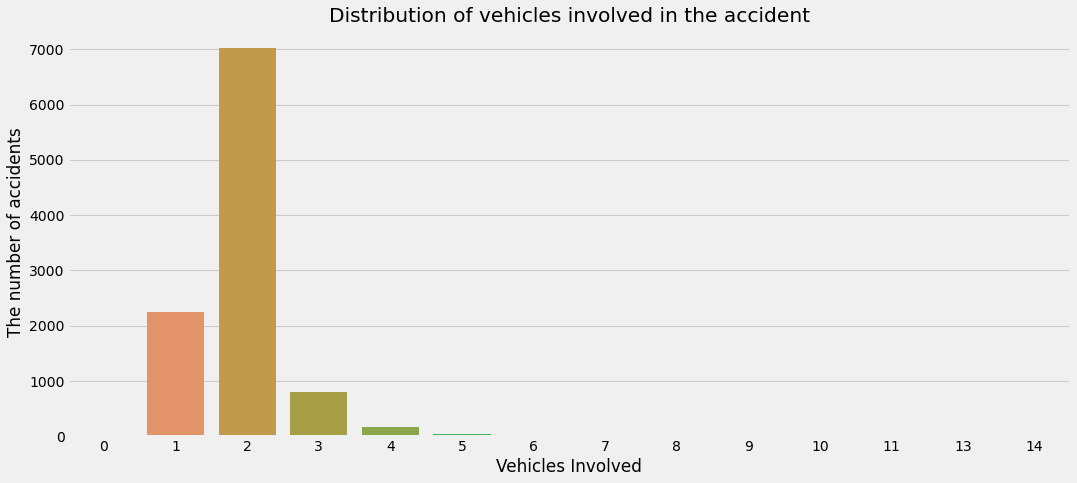

In [35]:
# Number of accident according to the number of vehicle involved
vehicles_involved = data.Vehicles_involved.value_counts()

plt.figure(figsize = (16, 7))
plt.style.use('fivethirtyeight')
sns.barplot(x = vehicles_involved.index, y = vehicles_involved.values)

plt.title('Distribution of vehicles involved in the accident')
plt.xlabel('Vehicles Involved')
plt.ylabel('The number of accidents')
plt.show()

In most accidents, two vehicles were involved (7028 accidents in 2017). Furthermore, the police recorded car accidents where up to 14 vehicles were involved; however, car accidents with many vehicles are not common.

## Mild — Serious injuries

The data frame includes information about how many victims suffered mild and serious injuries in each car accident. We can easily represent the percentage of mild and serious injuries using a pie plot as follows:

In [36]:
injuries = data[['Mild_injuries', 'Serious_injuries']].sum()
injuries

Mild_injuries       11929
Serious_injuries      241
dtype: int64

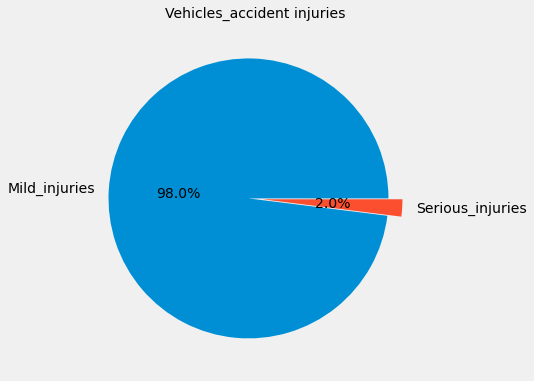

In [37]:
plt.style.use('fivethirtyeight')
pie, ax = plt.subplots(figsize=[10,6])
labels = injuries.index
plt.pie(x=injuries, autopct="%.1f%%", explode=[0.05]*2, labels= labels, pctdistance=0.5)

plt.title("Vehicles_accident injuries", fontsize=14);
pie.savefig("DeliveryPieChart.png")
plt.show()

The plot shows that only 2% of the injuries are serious injuries. Although most of the injuries in car accidents were mild, it would be interesting to analyze under which circumstances (time, date, location) serious injuries are more frequent.

## Rate of Injuries type by day of the week

The following plot shows the percentage of injuries according to the day of the week.

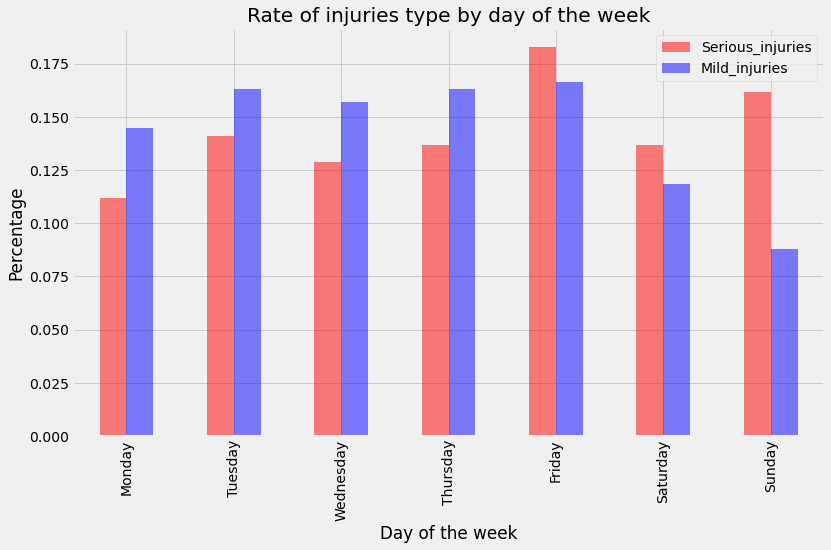

In [38]:
# number of serious injuries per day of the week
serious_accident = data[data['Serious_injuries']!= 0].groupby(data.date.dt.dayofweek).sum().Serious_injuries

# percentage of serious injuries per day of the week
percent_serious = serious_accident/serious_accident.sum()

# number of mild injuries per day of the week
mild_accident = data[data['Mild_injuries']!= 0].groupby(data.date.dt.dayofweek).sum().Mild_injuries

# percentage of serious injuries per day of the week
percent_mild = mild_accident/mild_accident.sum()

# combine both series to dataframe in order to plot them side by side

rates = pd.DataFrame({'Serious_injuries':percent_serious, 'Mild_injuries':percent_mild})

plt.style.use('fivethirtyeight')
rates.plot(kind = 'bar', figsize = (12,7), color = ['red', 'blue'], alpha = 0.5)

plt.title('Rate of injuries type by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Percentage')
plt.xticks(np.arange(7), [calendar.day_name[x] for x in range(0,7)])
plt.show()

We can also plot the percentage of injuries according to the hour.

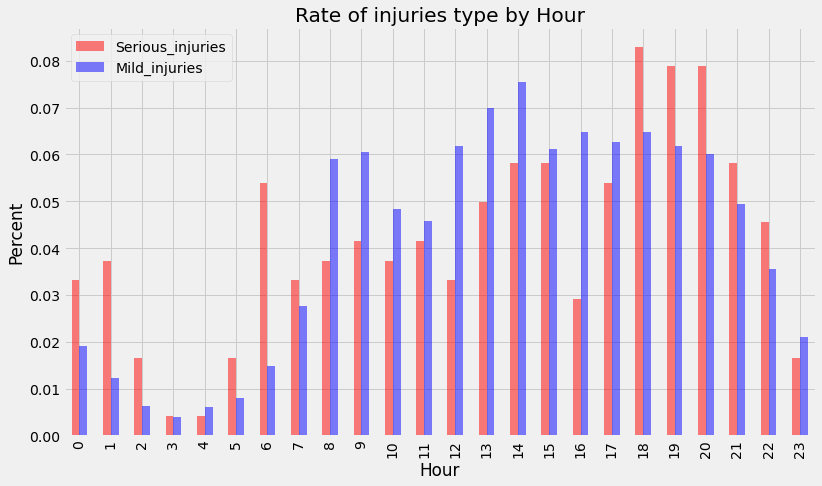

In [39]:
# number of serious injuries per day of the week
serious_accident = data[data['Serious_injuries']!= 0].groupby(data.date.dt.hour).sum().Serious_injuries

# percentage of serious injuries per day of the week
percent_serious = serious_accident/serious_accident.sum()

# number of mild injuries per day of the week
mild_accident = data[data['Mild_injuries']!= 0].groupby(data.date.dt.hour).sum().Mild_injuries

# percentage of serious injuries per day of the week
percent_mild = mild_accident/mild_accident.sum()

# combine both series to dataframe in order to plot them side by side

rates = pd.DataFrame({'Serious_injuries':percent_serious, 'Mild_injuries':percent_mild})

plt.style.use('fivethirtyeight')
rates.plot(kind = 'bar', figsize = (12,7), color = ['red', 'blue'], alpha = 0.5)

plt.title('Rate of injuries type by Hour')
plt.xlabel('Hour')
plt.ylabel('Percent')
plt.show()

As we can observe, accidents tend to be more severe in late-evening and night.

__Type of accident analysis — conclusions__

1. In most accidents, 1,2, or 3 vehicles were involved. The police of Barcelona registered in 2017 car accidents were up to 14 vehicles where involved.
2. Most of the people injured in car accidents in 2017 suffered mild injuries (98%).
3. Accidents tend to be more severe during night, late-evening, and weekends.

## Location analysis

In [46]:
barca_map = folium.Map(location = [41.38879, 2.15899], zoom_start = 12)

# display the map
barca_map

The dataset includes the latitude and longitude of each car accident. We can easily visualize them by using circle markers. The following map shows the accidents where serious injuries were caused, displaying the number of serious injuries with a popup label.


In [61]:
# map object of the city of barcelona
barca_map = folium.Map(location = [41.38879, 2.15899], zoom_start = 12)

# accident where serious injuries were occured
for lat, long, labels in zip(data.Latitude, data.Longitude, data.Serious_injuries.astype(str)):
    if labels != '0':
        folium.CircleMarker(
        [lat, long],
        radius = 3,
        color = 'red',
        fill = True,
        popup = labels,
        fill_color = 'darkred',
        fill_opacity = 0.6).add_to(barca_map)
        
# shwo map
barca_map

In Folium, we can also group markers into different clusters using the MarkerCluster object. The following plot depicts car accidents with seriously injured victims as before, but this time the accidents are group into clusters.

In [69]:
# map object of the city of barcelona
barca_map = folium.Map(location = [41.38879, 2.15899], zoom_start = 12)

# mark cluster object for the car accidents
accidents = plugins.MarkerCluster().add_to(barca_map)

# accident where serious injuries were occured
for lat, long, labels in zip(data.Latitude, data.Longitude, data.Serious_injuries.astype(str)):
    if labels != '0':
        folium.Marker(
            location = [lat, long],
            icon = None,
            color = 'red',
            popup = labels).add_to(accidents)
        
# shwo map
barca_map


One striking feature of Folium is the possibility of creating animated heat maps, changing the data being shown based on a certain dimension (e.g. hours). We can easily achieve that by using the HeatMapWithTime() class method. First, we create a nested list where each position contains the latitude and longitude of all car accidents in that specific hour.

In [73]:
from folium.plugins import HeatMapWithTime

# map object of the city of barcelona
barca_map = folium.Map(location = [41.38879, 2.15899], zoom_start = 12)

# Nested list that contains both the latitude and longitude of different accidents
hour_list = [[] for i in range(24)]
for lat, long, hour in zip(data.Latitude, data.Longitude, data.date.dt.hour):
    hour_list[hour].append([lat, long])
    
# labels indicating hour
index = [str(i) + ' Hours' for i in range(24)]

# Heatmap with the time object for the car accidents
HeatMapWithTime(hour_list, index).add_to(barca_map)

barca_map

Looking at the above timeline, we can observe how the number of accidents increases from 8 hours, remaining high until 21 hours when starts to decrease.

# Thanks for Reading !